# LSTM for blood glucose level predition

Using LSTM to predict next day glucose values of Wally based on previous day values.


In [22]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [79]:
import numpy
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import LSTM, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
%matplotlib inline
seed = 7
numpy.random.seed(seed)

In [12]:
path = Path('.')
iter =path.iterdir()
[i for i in iter]

[PosixPath('wally-glucose.ipynb'),
 PosixPath('.DS_Store'),
 PosixPath('Untitled.ipynb'),
 PosixPath('line-keras.ipynb'),
 PosixPath('square-keras.ipynb'),
 PosixPath('README.md'),
 PosixPath('plotting-with-keras.ipynb'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('.git'),
 PosixPath('data')]

Load Wally CSV File

In [31]:
wally_data = path / 'data/wally_glucose.csv'
df = pd.read_csv(wally_data)
df.head(10)

,Date,Insulin,Amps,Amps+6,Pmps,Pmps+3
0,2/9/2019,8.5,267,350,300,120
1,2/10/2019,8.5,113,60,129,148
2,2/11/2019,8.5,267,65,100,79
3,2/12/2019,7.5,242,100,72,72
4,2/13/2019,5.5,268,159,72,79
5,2/14/2019,3.5,180,129,119,53
6,2/15/2019,3.0,209,281,315,281
7,2/16/2019,3.5,191,92,138,181
8,2/17/2019,3.5,268,280,224,129
9,2/18/2019,3.5,231,215,158,126


Let's plot some data to better understand how glucose levels are moving


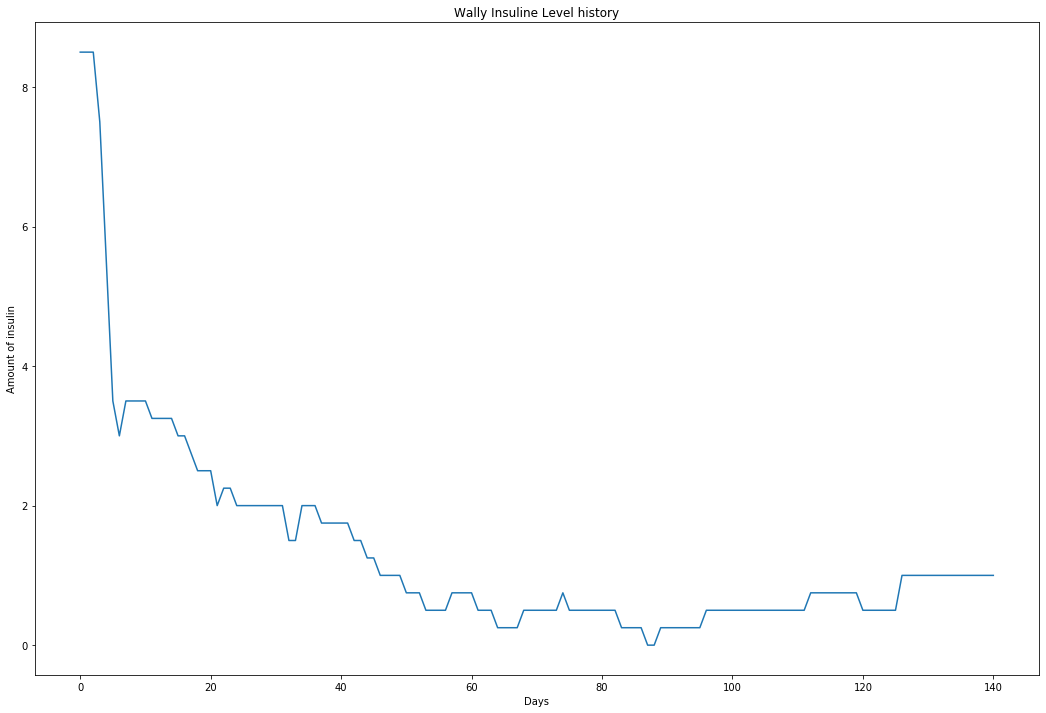

In [36]:
plt.figure(figsize=(18,12))
plt.plot(df["Insulin"])
plt.title("Wally Insuline Level history")
plt.xlabel('Days')
plt.ylabel('Amount of insulin')
plt.show()

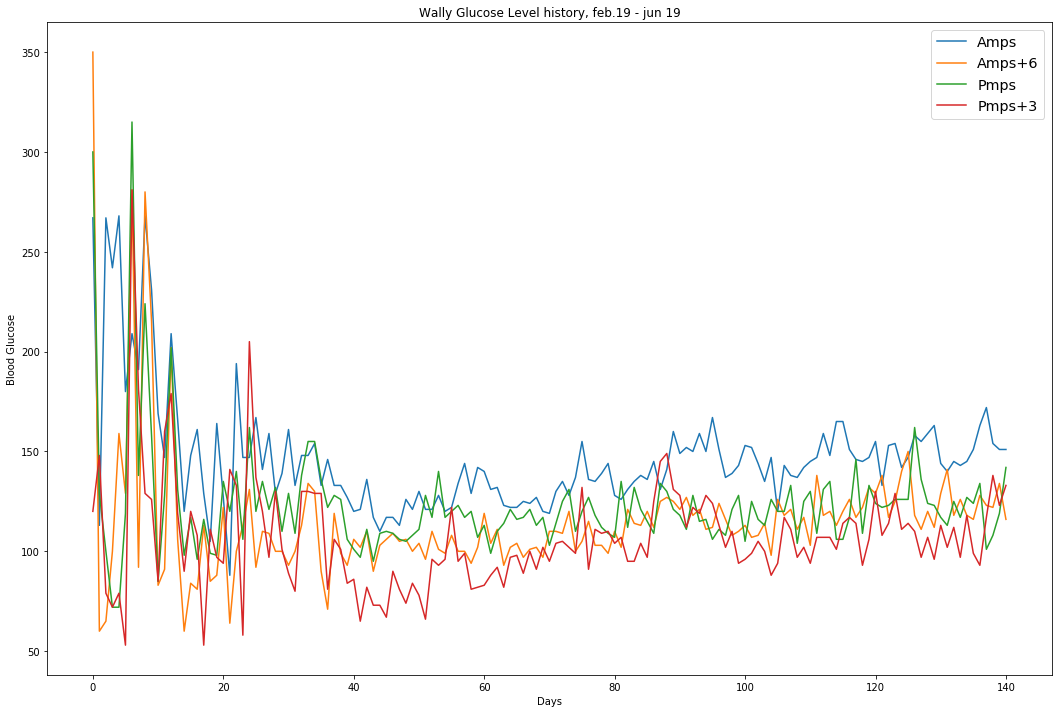

In [64]:
plt.figure(figsize=(18,12))
plt.plot(df["Amps"])
plt.plot(df["Amps+6"])
plt.plot(df["Pmps"])
plt.plot(df["Pmps+3"])
plt.title("Wally Glucose Level history, feb.19 - jun 19")
plt.xlabel('Days')
plt.ylabel('Blood Glucose')
plt.legend(['Amps', 'Amps+6', 'Pmps', 'Pmps+3'], loc='upper right', fontsize='x-large')
plt.show()

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(df["Amps"][-60:])
plt.plot(df["Amps+6"][-60:])
plt.plot(df["Pmps"][-60:])
plt.plot(df["Pmps+3"][-60:])
plt.plot(df["Insulin"][-60:]*100)
plt.title("Wally Glucose Level history, last 60 days")
plt.xlabel('Days')
plt.ylabel('Blood Glucose')
plt.legend(['Amps', 'Amps+6', 'Pmps', 'Pmps+3', 'Insulin'], loc='upper left', fontsize='x-large')
plt.show()

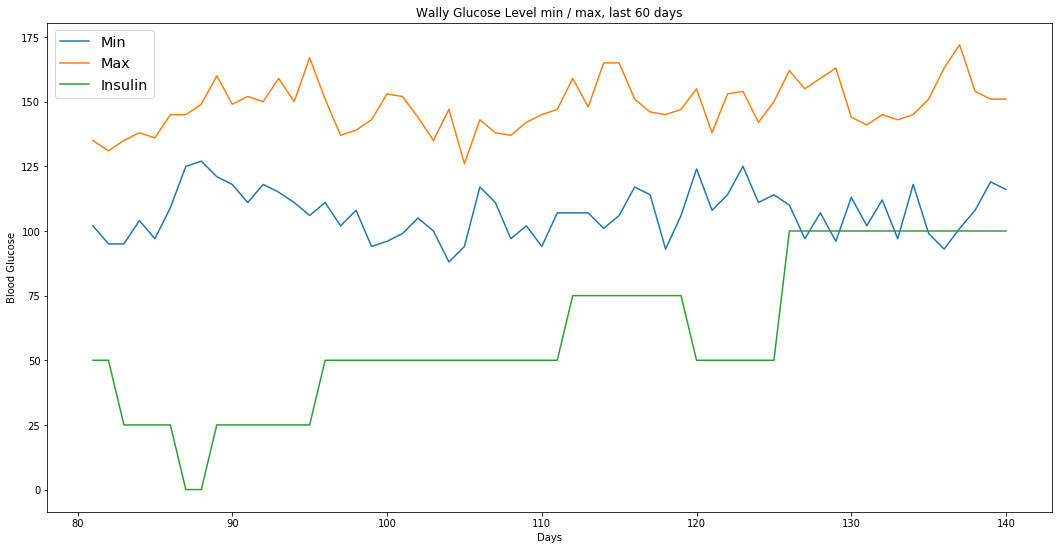

In [55]:
plt.figure(figsize=(18,9))
gmin = np.minimum(df["Amps"][-60:], df["Amps+6"][-60:])
gmin = np.minimum(gmin,  df["Pmps"][-60:])
gmin = np.minimum(gmin, df["Pmps+3"][-60:])

gmax = np.maximum(df["Amps"][-60:], df["Amps+6"][-60:])
gmax = np.maximum(gmax,  df["Pmps"][-60:])
gmax = np.maximum(gmax, df["Pmps+3"][-60:])
plt.plot(gmin)
plt.plot(gmax)
plt.plot(df["Insulin"][-60:]*100)
plt.title("Wally Glucose Level min / max, last 60 days")
plt.xlabel('Days')
plt.ylabel('Blood Glucose')
plt.legend(['Min', 'Max', 'Insulin'], loc='upper left', fontsize='x-large')
plt.show()

**Normalizind the data**


In [173]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Amps","Amps+6","Pmps","Pmps+3","Insulin"]
df_train = df
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)


In [174]:
x_train[0:5] # 0: Amps, 1: Amps+6, 2:Pmps, 3: Pmps+3, 4: Insulin

array([[0.99444444, 1.        , 0.9382716 , 0.29385965, 1.        ],
       [0.13888889, 0.        , 0.2345679 , 0.41666667, 1.        ],
       [0.99444444, 0.01724138, 0.11522634, 0.11403509, 1.        ],
       [0.85555556, 0.13793103, 0.        , 0.08333333, 0.88235294],
       [1.        , 0.34137931, 0.        , 0.11403509, 0.64705882]])

In [175]:
def build_timeseries(mat, time_steps):
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - time_steps
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, time_steps, dim_1))
    y = np.zeros((dim_0, 4))
    
    for i in range(dim_0):
        x[i] = mat[i:time_steps+i]
        y[i] = mat[time_steps+i, 0:4]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [176]:
x_t, y_t = build_timeseries(x_train, 15)

length of time-series i/o (126, 15, 5) (126, 4)


**Create the model**

In [177]:
batch_size = 1
time_steps = 15
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(batch_size, time_steps, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(4,activation='sigmoid'))
#optimizer = optimizers.RMSprop(lr=lr)
lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [178]:
history = lstm_model.fit(x_t, y_t, epochs=100, verbose=2, batch_size=1,
                    shuffle=False)

Epoch 1/100
 - 5s - loss: 0.0116
Epoch 2/100
 - 3s - loss: 0.0064
Epoch 3/100
 - 2s - loss: 0.0054
Epoch 4/100
 - 3s - loss: 0.0053
Epoch 5/100
 - 3s - loss: 0.0052
Epoch 6/100
 - 3s - loss: 0.0046
Epoch 7/100
 - 3s - loss: 0.0050
Epoch 8/100
 - 3s - loss: 0.0046
Epoch 9/100
 - 3s - loss: 0.0052
Epoch 10/100
 - 3s - loss: 0.0051
Epoch 11/100
 - 3s - loss: 0.0049
Epoch 12/100
 - 3s - loss: 0.0048
Epoch 13/100
 - 3s - loss: 0.0047
Epoch 14/100
 - 3s - loss: 0.0046
Epoch 15/100
 - 3s - loss: 0.0047
Epoch 16/100
 - 3s - loss: 0.0048
Epoch 17/100
 - 3s - loss: 0.0044
Epoch 18/100
 - 3s - loss: 0.0047
Epoch 19/100
 - 3s - loss: 0.0049
Epoch 20/100
 - 3s - loss: 0.0048
Epoch 21/100
 - 3s - loss: 0.0048
Epoch 22/100
 - 3s - loss: 0.0048
Epoch 23/100
 - 3s - loss: 0.0048
Epoch 24/100
 - 3s - loss: 0.0047
Epoch 25/100
 - 3s - loss: 0.0044
Epoch 26/100
 - 3s - loss: 0.0044
Epoch 27/100
 - 3s - loss: 0.0043
Epoch 28/100
 - 3s - loss: 0.0047
Epoch 29/100
 - 3s - loss: 0.0044
Epoch 30/100
 - 3s - lo

In [179]:
history.history.keys()

dict_keys(['loss'])

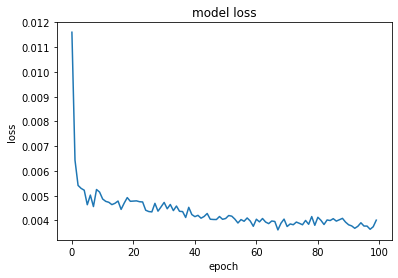

In [180]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [183]:
p = np.reshape(x_t[124], (1, 15, 5))
out=lstm_model.predict(p)   # Predict values based of previous 15 days
out = np.append(out, [0,]) # We add Insulin 0 to the output

In [172]:
inverse = min_max_scaler.inverse_transform(x_t[94])
inverse

array([[150.  , 111.  , 116.  , 128.  ,   0.25],
       [167.  , 112.  , 106.  , 124.  ,   0.25],
       [151.  , 124.  , 111.  , 113.  ,   0.5 ],
       [137.  , 116.  , 108.  , 102.  ,   0.5 ],
       [139.  , 108.  , 121.  , 110.  ,   0.5 ],
       [143.  , 110.  , 128.  ,  94.  ,   0.5 ],
       [153.  , 113.  , 105.  ,  96.  ,   0.5 ],
       [152.  , 107.  , 125.  ,  99.  ,   0.5 ],
       [144.  , 108.  , 116.  , 105.  ,   0.5 ],
       [135.  , 114.  , 113.  , 100.  ,   0.5 ],
       [147.  ,  98.  , 126.  ,  88.  ,   0.5 ],
       [120.  , 126.  , 120.  ,  94.  ,   0.5 ],
       [143.  , 118.  , 120.  , 117.  ,   0.5 ],
       [138.  , 121.  , 133.  , 111.  ,   0.5 ],
       [137.  , 111.  , 104.  ,  97.  ,   0.5 ]])

In [184]:

out
out = min_max_scaler.inverse_transform([out])
out

array([[150.58569956, 124.09883738, 128.37934417, 115.18703854,
          0.        ]])